<h1><i><b>Analysis of CODE3</b></i></h1>
<i>

---


**Target:**


1.   Training the model under **less iterations** and restructuring the architecture for **less trainiable parameters** or complexity.
2.   Removing the large kernel in last layer and replacing it with **GAP**.



**Results:**

1.   Parameters: 8710
2.   Best Train Acc: 99.09(15th epoch)
3.   Best Test Acc: 98.90(13th epoch) and 98.74(in 15 th epoch)
4.   Difference : More train accuracy - Small overfit scenario
5.   Epoch - 15



**Analysis:**

1.   Model looks a bit overfit.
2.   Architecture looks simple overall and can be improved upon to attain good accuracy and prevent overfitting.



**RF Calculation**

```
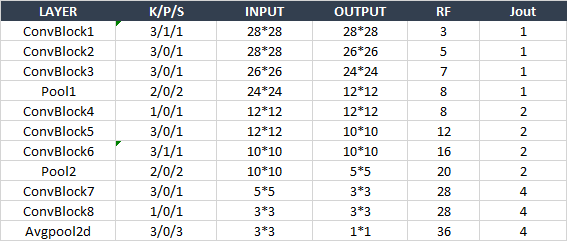

**IMPORTS**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

**DEFINE TEST/TRAIN TRANSFORMATIONS**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**LOAD MNIST DATA**

In [0]:
train = datasets.MNIST('./data', train=True, transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform=test_transforms, download=True)


**DATA LOADERS**

In [0]:
SEED = 1
np.random.seed(42)
torch.manual_seed(1)

#check for cuda
cuda = torch.cuda.is_available()
print('cuda available', cuda)

if cuda:
  torch.cuda.manual_seed(1)

#dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

cuda available True


**Data Stats**

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


**MODEL**

In [0]:
class Net(nn.Module):
     def __init__(self):
       super(Net, self).__init__()
       #Input block
       self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
       ) # output_size = 28

       #CONV BLOCK 1
       self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
       ) # output_size = 26

       self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU()
       ) #output size = 24
      
       #TRANSITION BLOCK
       self.pool1 = nn.MaxPool2d((2,2))  #out = 12
       self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1,1),padding=0, bias=False),
            nn.ReLU()
       ) #output = 12

       #CONV BLOCK 2
       self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
       ) # output_size = 10

       self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
            nn.ReLU()
       ) #out = 10

       #TRANSITION BLOCK2
       self.pool2 = nn.MaxPool2d((2,2)) #out 5
       self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU()
       ) #out = 3

       #OUTPUT BLOCK
       self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
            #nn.ReLU()  
       ) #out = 3

       self.gap = nn.Sequential(
            nn.AvgPool2d(3)
        ) # output_size = 1


     def forward(self, x):
       x = self.convblock1(x)
       x = self.convblock2(x)
       x = self.convblock3(x)
       x = self.pool1(x)
       x = self.convblock4(x)
       x = self.convblock5(x)
       x = self.convblock6(x)
       x = self.pool2(x)
       x = self.convblock7(x)
       x = self.convblock8(x)
       x = self.gap(x)
       x = x.view(-1, 10)
       return F.log_softmax(x, dim=-1)

**RF Calculation**

```
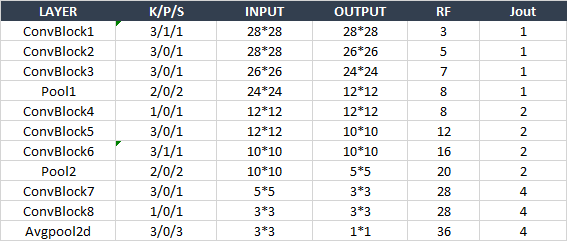

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 12, 26, 26]           1,080
              ReLU-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,512
              ReLU-6           [-1, 14, 24, 24]               0
         MaxPool2d-7           [-1, 14, 12, 12]               0
            Conv2d-8           [-1, 10, 12, 12]             140
              ReLU-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
           Conv2d-12           [-1, 16, 10, 10]           1,728
             ReLU-13           [-1, 16, 10, 10]               0
        MaxPool2d-14             [

**Define Train/Test functions with loss and accuracy calculations**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Training the MODEL with validation accuracy check**

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.2960686683654785 Batch_id=937 Accuracy=12.79: 100%|██████████| 938/938 [00:13<00:00, 71.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2982, Accuracy: 1111/10000 (11.11%)

EPOCH: 1


Loss=0.4074481725692749 Batch_id=937 Accuracy=71.85: 100%|██████████| 938/938 [00:13<00:00, 69.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1210, Accuracy: 9637/10000 (96.37%)

EPOCH: 2


Loss=0.06683804094791412 Batch_id=937 Accuracy=96.43: 100%|██████████| 938/938 [00:12<00:00, 72.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0825, Accuracy: 9732/10000 (97.32%)

EPOCH: 3


Loss=0.1310737133026123 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:13<00:00, 71.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9827/10000 (98.27%)

EPOCH: 4


Loss=0.015470355749130249 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:13<00:00, 72.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9844/10000 (98.44%)

EPOCH: 5


Loss=0.006441593170166016 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:13<00:00, 70.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9842/10000 (98.42%)

EPOCH: 6


Loss=0.10907210409641266 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:13<00:00, 71.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9843/10000 (98.43%)

EPOCH: 7


Loss=0.13069310784339905 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:13<00:00, 71.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9861/10000 (98.61%)

EPOCH: 8


Loss=0.001708000898361206 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:12<00:00, 72.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9862/10000 (98.62%)

EPOCH: 9


Loss=0.006439343094825745 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:13<00:00, 71.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9854/10000 (98.54%)

EPOCH: 10


Loss=0.014025390148162842 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:12<00:00, 72.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9844/10000 (98.44%)

EPOCH: 11


Loss=0.036995261907577515 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:12<00:00, 72.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9869/10000 (98.69%)

EPOCH: 12


Loss=0.0018907487392425537 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:12<00:00, 73.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9890/10000 (98.90%)

EPOCH: 13


Loss=0.0004087090492248535 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:12<00:00, 73.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9869/10000 (98.69%)

EPOCH: 14


Loss=0.003919929265975952 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:12<00:00, 72.60it/s]



Test set: Average loss: 0.0409, Accuracy: 9874/10000 (98.74%)



Text(0.5, 1.0, 'Test Accuracy')

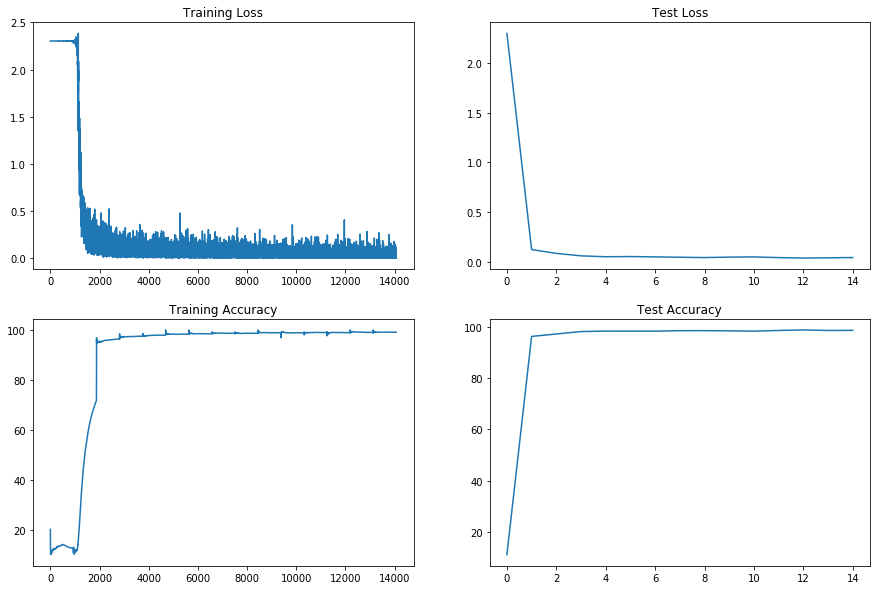

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")